# Code to generate Supplemental Figure S10g and S10h


## Requirements for running this notebook

### Environment

1. You'll need Python 3.5.2

2. In the root directory of the repository, set up a virtual enrivonment: `python3 -m venv venv/`

3. Activate the virtual environment `source venv/bin/activate .`

4. Inside the virtual environment (you should see `"(venv)"` prefixed to your terminal prompt), install requirements `pip install -r venv_requirements/requirements-py3.txt`. 

## Imports and set seeds for reproducibility

In [1]:
import sys
import os
import random

import numpy as np
import matplotlib     
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
from matplotlib.colors import ListedColormap


from sklearn.decomposition import IncrementalPCA
from sklearn.externals import joblib

sys.path.append('../../common/')
import plot_style_utils

import common

%reload_ext autoreload
%autoreload 2

np.random.seed(1)
random.seed(1)

## Grab the required data

`awscli` is required for the dataset downloads below. It is installed in the virtual environment, and if you've set that up properly, the command below should just work.

In [2]:
DATA_DIR = '../../data/supp_fig_10gh/'
os.makedirs(DATA_DIR, exist_ok=True)

common.sync_dataset('gfp_sarkisyan_baseline_reps', DATA_DIR)
common.sync_dataset('gfp_gen_set_baseline_reps', DATA_DIR)

common.sync_dataset('gfp_sarkisyan_evotuned_unirep', DATA_DIR)
common.sync_dataset('gfp_gen_set_evotuned_unirep', DATA_DIR)


aws s3 cp --no-sign-request s3://protein-representation-learning/mlpe_gfp/generalization_mechanism/reps_sarkisyan.dict.joblibpkl ../../data/supp_fig_10gh/
aws s3 cp --no-sign-request s3://protein-representation-learning/mlpe_gfp/generalization_mechanism/all_fpbase_reps.dict.joblibpkl ../../data/supp_fig_10gh/
aws s3 cp --no-sign-request s3://protein-representation-learning/mlpe_gfp/evotune/sark_sfGFP_finetune1_avg_hidden.npz ../../data/supp_fig_10gh/
aws s3 cp --no-sign-request s3://protein-representation-learning/mlpe_gfp/generalization_mechanism/finetune1_fpbase_reps.npy ../../data/supp_fig_10gh/


## Set up the plotting context

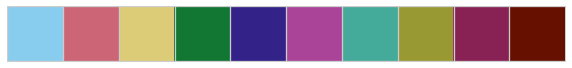

In [3]:
plot_style_utils.set_pub_plot_context(context="talk", colors="categorical")
CAT_COLORS = sns.color_palette()
tmp = CAT_COLORS[3]
CAT_COLORS[3] = CAT_COLORS[7]
CAT_COLORS[7] = tmp
MPL_CMAP = ListedColormap(sns.color_palette().as_hex())

sns.palplot(sns.color_palette())
plt.show()

## First load up a dictionary of representations for the Sarkisyan dataset and the FPbase augmented dataset.

The Sarkisyan dataset consists of ~50K avGFP mutants sampled from the local fitness landscape of avGFP. 

The FPbase augmented dataset is what we use to assess generalization in Figure 4. It consists of several GFP homologs and engineered variants that are distant to avGFP. The dataset is augmented with mutants (1-12 mutations) of each of theses parent sequences.

In [4]:
sark_rep_file = common.dataset_name_to_local_path('gfp_sarkisyan_baseline_reps', DATA_DIR)
fpbase_rep_file = common.dataset_name_to_local_path('gfp_gen_set_baseline_reps', DATA_DIR)

baseline_sark_reps = joblib.load(sark_rep_file)
baseline_fpbase_reps = joblib.load(fpbase_rep_file)

## Evaluate the mechanism behind why the baseline Doc2Vec representation does not generalize well

For the visualization, we downsample to 1K datapoints randomly.

In [5]:
BASELINE_REPRESENTATION = 'random_3_7.pkl' # Best performing Doc2Vec model. As seen in Fig 4.

sark_baseline_rep = baseline_sark_reps[BASELINE_REPRESENTATION]['X_train']
fpbase_baseline_rep = baseline_fpbase_reps[BASELINE_REPRESENTATION]

sark_downsample_idx = np.random.permutation(sark_baseline_rep.shape[0])[:1000]
fpbase_downsample_idx = np.random.permutation(fpbase_baseline_rep.shape[0])[:1000]

Learn the principal components of the baseline representation. The PCs are learned on the FULL sarkisyan and fpbase dataset combined.

In [6]:
baseline_ipca = IncrementalPCA(n_components=3, whiten=True, batch_size=5000)
baseline_ipca.fit(np.vstack((sark_baseline_rep, fpbase_baseline_rep)))
sark_baseline_s = baseline_ipca.transform(sark_baseline_rep[sark_downsample_idx])
fpbase_baseline_s = baseline_ipca.transform(fpbase_baseline_rep[fpbase_downsample_idx])

Visualize

/home/ubuntu/GitHub/UniRep-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


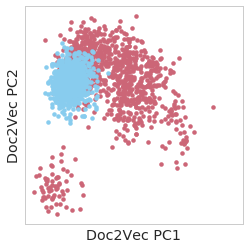

In [7]:
XPC = 0
YPC = 1

fig = plt.figure(figsize=(4,4))
plt.plot(fpbase_baseline_s[:,XPC], fpbase_baseline_s[:,YPC], '.', color=CAT_COLORS[1], alpha=1)
plt.plot(sark_baseline_s[:,XPC], sark_baseline_s[:,YPC], '.', color=CAT_COLORS[0], alpha=1)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.xlabel('Doc2Vec PC1')
plt.ylabel('Doc2Vec PC2')

plt.show()

The projection of the Sarkisyan represented sequences are in blue. The projection of the FPBase sequences are in red. As you can see there isn't a good overlap between the two distributions. This is one explanation why Doc2Vec doesn't generalize well. 

## Evotuned UniRep

Repeat the exact same workflow but for Evotuned UniRep. Note internally, we referred to Evotuned UniRep as `finetune1`, hence that reference in the code below.

In [8]:
sark_evouni_rep_file = common.dataset_name_to_local_path('gfp_sarkisyan_evotuned_unirep', DATA_DIR)
fpbase_evouni_rep_file = common.dataset_name_to_local_path('gfp_gen_set_evotuned_unirep', DATA_DIR)

sark_evouni_rep = np.load(sark_evouni_rep_file)['X_train']
fpbase_evouni_rep = np.load(fpbase_evouni_rep_file)

sark_downsample_idx = np.random.permutation(sark_evouni_rep.shape[0])[:1000]
fpbase_downsample_idx = np.random.permutation(fpbase_evouni_rep.shape[0])[:1000]

In [9]:
evouni_ipca = IncrementalPCA(n_components=3, whiten=True, batch_size=5000)
evouni_ipca.fit(np.vstack((sark_evouni_rep, fpbase_evouni_rep)))

IncrementalPCA(batch_size=5000, copy=True, n_components=3, whiten=True)

In [10]:
sark_evouni_s = evouni_ipca.transform(sark_evouni_rep[sark_downsample_idx])
fpbase_evouni_s = evouni_ipca.transform(fpbase_evouni_rep[fpbase_downsample_idx])

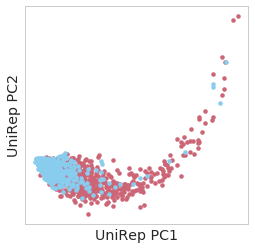

In [11]:
fig = plt.figure(figsize=(4,4))
plt.plot(fpbase_evouni_s[:,XPC], fpbase_evouni_s[:,YPC], '.', color=CAT_COLORS[1], alpha=1)
plt.plot(sark_evouni_s[:,XPC], sark_evouni_s[:,YPC], '.', color=CAT_COLORS[0], alpha=1)
plt.xticks([])
#plt.xlim((0, 5.2))
plt.yticks([])
plt.xlabel('UniRep PC1')
plt.ylabel('UniRep PC2')

plt.show()